# Parameter Estimation of DNA mutants

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).  

In [23]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# library for calculating stats and plotting
sys.path.insert(0,'../../../')
import mut.stats as stats
import mut.viz as viz
viz.plotting_style()

# Library to perform MCMC sampling
import emcee

# load in posterior distribution function,
# and scripts to handle the data
sys.path.insert(0, 'logpost/')
import logpost_dna as mcmc_utils

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

from collections import OrderedDict

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

In this analysis, we will begin by fitting the wild-type O2 dataset to check whether we get something similar to our previous work. Next we will move on and consider the wild-type data along with the other DNA mutants (Q21A, Q21M, Y20I). Note that this data includes an IPTG titration (R260 strain), RBS titration (4 rbs strains at 0 IPTG), and for the Q21M strain, microscopy was performed (flow cytometry otherwise). We will start by considering only the rbs titration and fit binding energies with this data. Then we will consider all the data re-fit the binding energies.

Note also that we will take our previous values for ea, ei, R, and the wild-type O2 binding energy as priors in this new analysis.

This  analysis will give us a sense for how well the data handles only allowing a single parameter change (i.e., the binding energy). 

## Load in the data

In [5]:
# Load all of the 2018 flow data.
flow_files = glob.glob('../../processing/2018*DNA*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)
flow_data = flow_data[(flow_data.mutant!='Q21M') | (flow_data.IPTGuM != 0.0) ]

# Load the microscopy data
mic_files = glob.glob('../../processing/2018*microscopy*/output/*fold_change.csv')
dfs = [pd.read_csv(f) for f in mic_files]
mic_data = pd.concat(dfs, axis=0)
mic_data['IPTGuM'] = 0.0
mic_data['operator'] = 'O2'

df = pd.concat([flow_data, mic_data], ignore_index=True)
df = df[(df['fold_change'] >= 0.0) & (df['fold_change'] <= 1.3)]
df = df.reset_index()

# Now we remove the autofluorescence and delta values
df = df[(df.mutant != 'auto') & (df.mutant != 'delta') & (df.operator == 'O2')
       & (df.mutant != 'none')]

# Restart index
df = df.reset_index()

df.head()

,level_0,index,IPTGuM,Unnamed: 0,date,fold_change,mean_FITC_H,mean_YFP,mutant,operator,repressors,run_number,strain,username
0,2,4,0.1,17.0,20180213,0.001042,5032.407459,NaN,Q21M,O2,260.0,NaN,R260,gchure
1,4,7,0.1,34.0,20180213,0.004665,5077.456220,NaN,wt,O2,260.0,NaN,R260,gchure
2,5,8,0.1,63.0,20180213,0.007875,5117.362892,NaN,Q21M,O2,60.0,NaN,R60,gchure
3,7,10,5.0,5.0,20180213,0.048446,5615.077769,NaN,Q21M,O2,60.0,NaN,R60,gchure
4,10,14,5.0,50.0,20180213,0.046108,5586.131920,NaN,wt,O2,260.0,NaN,R260,gchure


# Running the MCMC with DNA mutant data

## Lets begin and run MCMC on all the DNA binding mutants and 0 IPTG 

In [7]:
# grab only IPTG = 0 uM data
df_trim = df[(df.IPTGuM==0.0)]# & (df.mutant=='Q21M')]

df_trim = df_trim[['strain','fold_change','mutant','operator', 'repressors', 'IPTGuM']]

In [8]:
# Preprocess the data
unique_var, param_idx, data = mcmc_utils.mcmc_pre_process(df_trim)

n_walkers = 50
n_burn = 500
n_steps = 8000
p0, n_dim = mcmc_utils.init_walkers(df_trim, n_walkers, unique_var, param_idx)
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, mcmc_utils.log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [9]:
unique_var

[array([   60.,   124.,   260.,  1220.]),
 array(['Q21A', 'Q21M', 'Y20I', 'wt'], dtype=object)]

## Run the MCMC

In [9]:
sample = False
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../../../data/mcmc/NB_emcee_mutants_DNA_rbsonly_strict.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    output.close()
    output = open('../../../../data/mcmc/NB_emcee_mutants_DNA_rbsonly_lnprob_strict.pkl', 'wb')
    pickle.dump(sampler.flatlnprobability, output)
    output.close()

## Re-load in the chains, save as .csv, and calculate properties

In [13]:
# Load the flat-chain
with open('../../../data/mcmc/NB_emcee_mutants_DNA_rbsonly_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
with open('../../../data/mcmc/NB_emcee_mutants_DNA_rbsonly_lnprob_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatlnprobability = unpickler.load()

# # Draw the corner plot
# fig = corner.corner(gauss_flatchain, bins=50, plot_contours=False,
#                     rasterized=True)

In [18]:
index = np.concatenate([['sigma'],
                      [mut + '_eps' for mut in unique_var[1]]])
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)
df_mcmc['lnprobability'] = gauss_flatlnprobability

# redfine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

,sigma,Q21A_eps,Q21M_eps,Y20I_eps,wt_eps,lnprobability
0,0.084261,-10.035394,-17.197280,-9.787810,-13.753123,149.950709
1,0.084261,-10.035394,-17.197280,-9.787810,-13.753123,149.950709
2,0.083457,-10.063867,-17.214267,-9.774833,-13.782326,151.175853
3,0.086673,-10.027994,-17.351024,-9.785757,-13.729930,149.461466
4,0.083980,-10.158955,-17.510276,-9.731234,-13.735230,153.593398


In [31]:
param_fit_DNA = stats.compute_statistics(df_mcmc, logprob_name='lnprobability')
param_fit_DNA.to_csv('param_fit_DNA_rbsonly_strict.csv')
param_fit_DNA.head()

,parameter,mode,hpd_min,hpd_max
0,sigma,0.076066,0.066049,0.091627
1,Q21A_eps,-10.285000,-10.436138,-10.122548
2,Q21M_eps,-15.194189,-17.998900,-14.069362
3,Y20I_eps,-9.683377,-9.839636,-9.525839
4,wt_eps,-13.900040,-14.298337,-13.526028


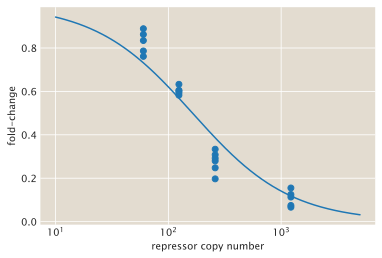

In [24]:
df_trim = df_trim[df_trim.mutant=='Q21A']
rep_cn = df_trim.repressors
fold_change = df_trim.fold_change
rep = np.arange(10,5000)
fold_change_pred = (1 + 2 * rep / 4.6E6 *(1 + np.exp(-4.5)) * np.exp(9.54))**-1


plt.scatter(rep_cn, fold_change)
plt.xscale('log')
# plt.yscale('log')
plt.plot(rep, fold_change_pred) 
plt.xlabel('repressor copy number')
plt.ylabel('fold-change')

## Now run MCMC on all the DNA binding mutants and all IPTG concentrations

In [28]:
# Preprocess the data
unique_var, param_idx, data = mcmc_utils.mcmc_pre_process(df)

n_walkers = 50
n_burn = 500
n_steps = 8000
p0, n_dim = mcmc_utils.init_walkers(df, n_walkers, unique_var, param_idx)
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, mcmc_utils.log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [27]:
unique_var

[array([   60.,   124.,   260.,  1220.]),
 array(['Q21A', 'Q21M', 'Y20I', 'wt'], dtype=object)]

In [29]:
sample = False
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../../data/mcmc/NB_emcee_mutants_DNA_strict.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    output.close()
    output = open('../../../data/mcmc/NB_emcee_mutants_DNA_lnprob_strict.pkl', 'wb')
    pickle.dump(sampler.flatlnprobability, output)
    output.close()

Load in the MCMC chains (and plot corner plots if desired)

In [30]:
# Load the flat-chain
with open('../../../data/mcmc/NB_emcee_mutants_DNA_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
with open('../../../data/mcmc/NB_emcee_mutants_DNA_lnprob_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatlnprobability = unpickler.load()


# # Draw the corner plot
# fig = corner.corner(gauss_flatchain, bins=50, plot_contours=False,
#                     rasterized=True)

In [20]:
# save as csv file
index = np.concatenate([['sigma'],
                      [mut + '_eps_r' for mut in unique_var[1]]])
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)
df_mcmc['lnprobability'] = gauss_flatlnprobability

df_mcmc.to_csv('../../../data/mcmc/NB_emcee_mutants_DNA_strict.csv')

Lets grab the best fit MAP and hpd values

In [32]:
param_fit_DNA = stats.compute_statistics(df_mcmc, logprob_name='lnprobability')
param_fit_DNA.to_csv('param_fit_DNA_strict.csv')
param_fit_DNA.head()

,parameter,mode,hpd_min,hpd_max
0,sigma,0.076066,0.066049,0.091627
1,Q21A_eps,-10.285000,-10.436138,-10.122548
2,Q21M_eps,-15.194189,-17.998900,-14.069362
3,Y20I_eps,-9.683377,-9.839636,-9.525839
4,wt_eps,-13.900040,-14.298337,-13.526028
